# Machine learning project: predicting will there be snow on christmas 2024

In [1]:
#import all relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Reading the data from Weather-dataset

data = pd.read_csv('WeatherDataset.csv')
data.drop(columns=['Observation station', 'Time [Local time]'], inplace=True)


In [3]:
#Create new binary_snow column 
max_snow_depth = data['Snow depth [cm]'].max()

binary_labels = [0, 1]
binary_cut_bins = [-1, 0, max_snow_depth]

binary_snow = pd.cut(data['Snow depth [cm]'], bins=binary_cut_bins, labels=binary_labels, include_lowest=True)
data.insert(7, 'binary_snow', binary_snow)

#convert -1 values to 0's
data['Precipitation amount [mm]'] = [0 if i == '-1' else i for i in data['Precipitation amount [mm]']]
data['Snow depth [cm]'] = [0 if i == '-1' else i for i in data['Snow depth [cm]']]

data.head()
print(len(data[data['Snow depth [cm]'] == '-1']))
print(len(data[data['Precipitation amount [mm]'] == '-1']))

0
0


## Preliminary analysis charts

In [4]:
#Plotting the average snow and precipitation from various years
data_december = data[data["Month"] == 12].copy()
for col in data_december.columns:
    data_december[col] = pd.to_numeric(data_december[col], errors='coerce')
    
    
snow_depth_avg = data_december.groupby('Year')['Snow depth [cm]'].mean()

precipitation_avg = data_december.groupby('Year')['Precipitation amount [mm]'].mean()


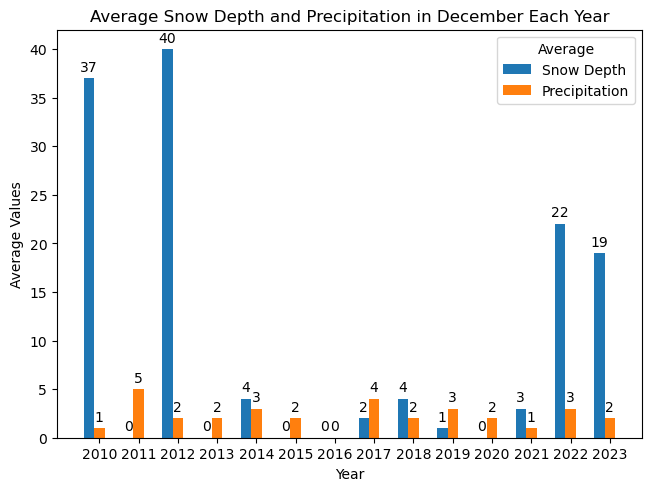

In [5]:
# Show the average snow and precipitation through the years
indeces = snow_depth_avg.index
values = (snow_depth_avg.values, precipitation_avg.values)
labels = ["Snow Depth", "Precipitation"]
colors = ["tab:red", "tab:blue"]

label_loc = np.arange(14)*3
width = 0.8
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i in range(2):
    offset = width * multiplier
    rectangles = ax.bar(label_loc + offset, np.round(values[i], decimals=0), label=labels[i])
    ax.bar_label(rectangles, padding=3)
    multiplier += 1
    

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Values')
ax.set_xticks(label_loc + width, indeces)
plt.title('Average Snow Depth and Precipitation in December Each Year')

# Add legend
plt.legend(title='Average')

# Show the plot
plt.show()

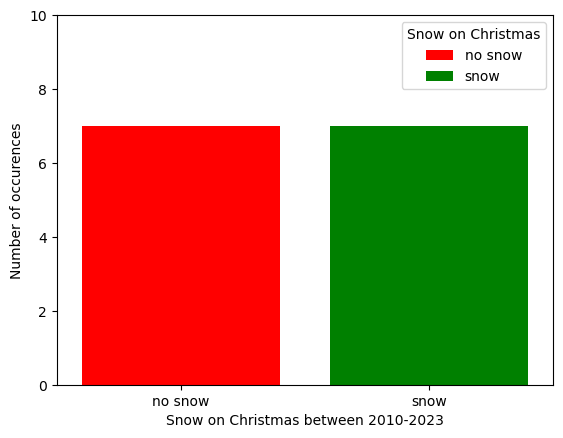

In [6]:
#Plotting which years has had snow on 24th december
data_christmas = data_december[data_december['Day'] == 24]

grouped_data = data_christmas.groupby('Year')['binary_snow'].mean()


fig, ax_ch = plt.subplots()

counts = grouped_data.value_counts()
value = ('no snow', 'snow')
labels = ('no snow', 'snow')
colors = ('red', 'green')

ax_ch.bar(value, counts, label=labels, color=colors)

ax_ch.set_ylabel('Number of occurences')
ax_ch.set_xlabel('Snow on Christmas between 2010-2023')
ax_ch.set_ylim(0,10)
ax_ch.set_xlim(-0.5,1.5)

ax_ch.legend(title='Snow on Christmas')
plt.show()

### Dataset Preprocessing

In [8]:
#creating Day of the year column and replacing Year, month and day columns
data['date_time'] = pd.to_datetime(data.iloc[:,0:3]) 
day_of_year = data['date_time'].dt.dayofyear

data.insert(3, 'Day of the year', day_of_year)
data.drop(columns=['Month', 'Day', 'date_time'], inplace=True)

data.head()

,Year,Day of the year,Precipitation amount [mm],Average temperature [°C]
count,5113.000000,5113.000000,5113.000000,5113.000000
mean,2016.499707,183.107373,1.609838,6.406474
std,4.031135,105.438599,4.309158,9.190455
min,2010.000000,1.000000,-1.000000,-25.000000
25%,2013.000000,92.000000,-1.000000,0.200000
50%,2016.000000,183.000000,0.100000,5.900000
75%,2020.000000,274.000000,1.900000,14.200000
max,2023.000000,366.000000,53.000000,26.600000


In [5]:
#Setting target variable 'y' and features
y = data['binary_snow']
X = data.drop(columns=['binary_snow'])
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X

,Year,Day of the year,Precipitation amount [mm],Snow depth [cm],Average temperature [°C],Minimum temperature [°C]
0,2010,1,0.1,41.0,-14.2,-16.9
1,2010,2,0.1,40.0,-18.9,-20.8
2,2010,3,1.1,38.0,-15.8,-25.6
3,2010,4,2.9,40.0,-6.8,-9.0
4,2010,5,0.6,44.0,-11.4,-19.1
...,...,...,...,...,...,...
5108,2023,361,0.2,28.0,-4.8,-8.1
5109,2023,362,1.0,28.0,-2.2,-5.7
5110,2023,363,8.1,30.0,-0.9,-1.9
5111,2023,364,1.4,36.0,-4.2,-6.3


In [6]:
#Normalize the dataset
scl = StandardScaler()

X_scaled = scl.fit_transform(X)

#insert Date column back into dataset
#X_scaled.insert(0, data['Date'])


In [7]:
#Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.25)
#Split temporary into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4) 

## Stage 2